<a href="https://colab.research.google.com/github/mihirk1/Disaster-Classification-through-Tweets/blob/main/DisasterClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload the training CSV file:


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving train.csv to train (13).csv
Upload the testing CSV file:


Saving test2.csv to test2.csv


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation mi

Epoch 0, Loss: 0.7245025038719177
Epoch 0, Loss: 0.7041342854499817
Epoch 0, Loss: 0.7047818303108215
Epoch 0, Loss: 0.6824281811714172
Epoch 0, Loss: 0.6910194158554077
Epoch 0, Loss: 0.6653050184249878
Epoch 0, Loss: 0.6570608615875244
Epoch 0, Loss: 0.68076092004776
Epoch 0, Loss: 0.6677519083023071
Epoch 0, Loss: 0.62437504529953
Epoch 0, Loss: 0.6002694368362427
Epoch 0, Loss: 0.6093252897262573
Epoch 0, Loss: 0.7465054988861084
Epoch 0, Loss: 0.5534965991973877
Epoch 0, Loss: 0.7766543626785278
Epoch 0, Loss: 0.6779029965400696
Epoch 0, Loss: 0.49998900294303894
Epoch 0, Loss: 0.5507222414016724
Epoch 0, Loss: 0.8449664115905762
Epoch 0, Loss: 0.8612453937530518
Epoch 0, Loss: 0.4654042422771454
Epoch 0, Loss: 0.39952725172042847
Epoch 0, Loss: 0.5093249678611755
Epoch 0, Loss: 0.42749905586242676
Epoch 0, Loss: 0.42895638942718506
Epoch 0, Loss: 0.41810712218284607
Epoch 0, Loss: 0.4490965008735657
Epoch 0, Loss: 0.4343467056751251
Epoch 0, Loss: 0.2975793480873108
Epoch 0, Loss

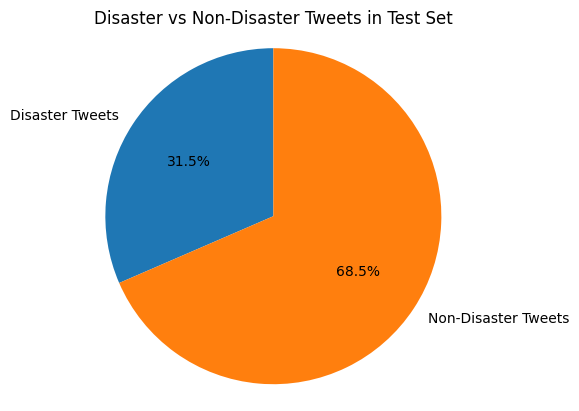

In [9]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from google.colab import files
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

# Upload CSV files
print("Upload the training CSV file:")
uploaded_train = files.upload()
print("Upload the testing CSV file:")
uploaded_test = files.upload()

def preprocess_tweet(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|<.*?>|@\w+|#\w+|\d+|[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [word for word in word_tokens if not word in stop_words]
    return ' '.join(filtered_sentence)

class DisasterTweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]  # Ensure labels are being retrieved here
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  # Ensure labels are included in the output dictionary
        }



def create_data_loader(df, tokenizer, max_len, batch_size, label_column='target'):
    ds = DisasterTweetDataset(
        tweets=df.text.to_numpy(),
        labels=df[label_column].to_numpy(),  # Pass the labels to the Dataset
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)



tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Ensure labels are loaded into the DataFrame and correctly passed to the DataLoader
train_df = pd.read_csv(next(iter(uploaded_train.keys())))
train_df['text'] = train_df['text'].apply(preprocess_tweet)

# Assuming 'label' is the column name for your training labels
train_df['target'] = train_df['target'].astype(int)  # Make sure label data is correctly typed as integers

train_loader = create_data_loader(train_df, tokenizer, max_len=128, batch_size=32, label_column='target')


# Load training data
train_df = pd.read_csv(next(iter(uploaded_train.keys())))
train_df['text'] = train_df['text'].apply(preprocess_tweet)

# Load testing data
test_df = pd.read_csv(next(iter(uploaded_test.keys())))
test_df['text'] = test_df['text'].apply(preprocess_tweet)

# Create data loaders
train_loader = create_data_loader(train_df, tokenizer, max_len=128, batch_size=32)
test_loader = create_data_loader(test_df, tokenizer, max_len=128, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Train the model
model.train()
for epoch in range(1):  # You can increase the number of epochs
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predict on the test data
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Count predictions
disaster_count = sum(predictions)
non_disaster_count = len(predictions) - disaster_count

print(f"Number of disaster tweets in test set: {disaster_count}")
print(f"Number of non-disaster tweets in test set: {non_disaster_count}")

# Plotting the results for the test set
labels = ['Disaster Tweets', 'Non-Disaster Tweets']
sizes = [disaster_count, non_disaster_count]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Disaster vs Non-Disaster Tweets in Test Set')
plt.show()